In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc
import seaborn as sns
import scipy.optimize as optimize
import scipy.stats as stats
from graphviz import Digraph
from tabulate import tabulate

## Motivation

A Bayesian network is a graphical model that captures the conditional dependence of variables via a [directed acyclic graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph).
Consider, for example, the following mixture model in which the outcome of a (possibly unfair) coin toss determines which of two normal distributions to sample from.

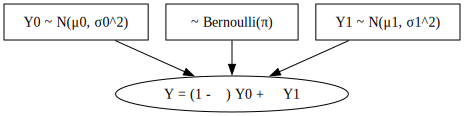

In [2]:
dot = Digraph()  # graph_attr={"rankdir": "LR"}
dot.node("Y0", "Y0 ~ N(μ0, σ0^2)", shape="rectangle")
dot.node("△", "△ ~ Bernoulli(π)", shape="rectangle")
dot.node("Y1", "Y1 ~ N(μ1, σ1^2)", shape="rectangle")
dot.node("Y", "Y = (1 - △) Y0 + △ Y1")
dot.edges([("Y0", "Y"), ("△", "Y"), ("Y1", "Y")])
dot

[Latent (a.k.a. unobservable) and observable](https://en.wikipedia.org/wiki/Latent_and_observable_variables) variables are distinguished in the graphical model by the use of rectangular and elliptic nodes.
Only the final result, $Y$, is observable.
The coin toss, for example, is not.
How does one estimate the parameters $\pi, \mu_0, \sigma_0, \mu_1, \sigma_1$ of this model?

Using the mixture model as a running example, this expository post considers [maximum likelihood estimators](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) and Bayesian estimators (e.g., [maximum a posteriori estimators](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) and [credible intervals](https://en.wikipedia.org/wiki/Credible_interval)) to answer the above.
More often than not, Bayesian networks do not have [closed forms](https://en.wikipedia.org/wiki/Closed-form_expression) for these estimators (or they are unwieldy) and hence iterative algorithms are needed.
Specifically, this post introduces **classical optimization methods** and **expectation maximization** (EM) for computing an MLE and **Markov Chain Monte Carlo** (MCMC) for computing Bayesian estimators.

## Transformation to unconstrained space

The first thing to note is that some of the parameters are constrained.
Namely, $\pi \in (0, 1)$ and $\sigma_i \in (0, \infty)$.
Some of the methods described in this post are either incompatible with or perform poorly in the presence of constraints.
In light of this, given parameters $\pi, \mu_0, \sigma_0, \mu_1, \sigma_1$, let

$$
\theta \equiv (\operatorname{logit} \pi, \mu_0, \log \sigma_0, \mu_1, \log \sigma_1).
$$

Note, in particular, that $\theta$ takes values in all of $\mathbb{R}^d$ with $d=5$.

In [3]:
def unconstrain(π, μ_0, σ_0, μ_1, σ_1):
    """Transform to unconstrained space."""
    logit_π = np.log(π / (1. - π))
    log_σ_0 = np.log(σ_0)
    log_σ_1 = np.log(σ_1)
    return logit_π, μ_0, log_σ_0, μ_1, log_σ_1

def constrain(θ):
    """Transform to constrained space."""
    logit_π, μ_0, log_σ_0, μ_1, log_σ_1 = θ
    π = 1. / (1. + np.exp(logit_π))
    σ_0 = np.exp(log_σ_0)
    σ_1 = np.exp(log_σ_1)
    return π, μ_0, σ_0, μ_1, σ_1

## Mixture model likelihood

Suppose we observe $N$ IID realizations of $Y$, the mixture model.
Denote these realizations $\boldsymbol{y} \equiv (y_1, \ldots, y_N)$.

In [4]:
# True parameters
π   = 0.5
μ_0 = 1.0
σ_0 = 0.7
μ_1 = 5.0
σ_1 = 1.0

N = 1_000

np.random.seed(0)
Δ   = np.random.uniform(size=N) < π
Y_0 = σ_0 * np.random.randn(N) + μ_0
Y_1 = σ_1 * np.random.randn(N) + μ_1
Y   = (1. - Δ) * Y_0 + Δ * Y_1

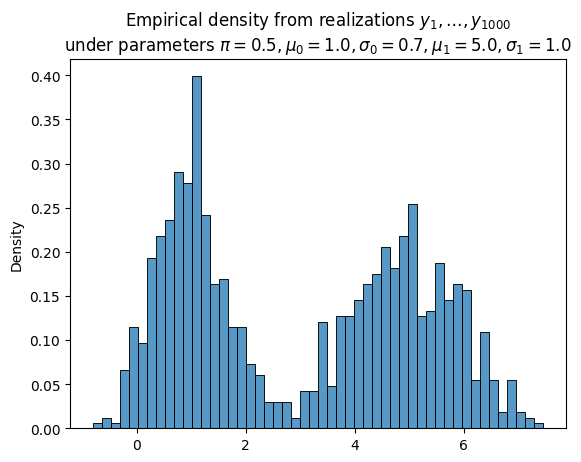

In [5]:
sns.histplot(data=Y, bins=50, stat="density")
plt.title(f"Empirical density from realizations $y_1, \ldots, y_{{{N}}}$\nunder parameters ${π=}, {μ_0=}, {σ_0=}, {μ_1=}, {σ_1=}$");

Given an arbitrary choice of parameters $\theta$ (not necessarily equal to the true parameters), the likelihood function gives us a way to quantify their goodness:

$$
L(\theta)
\equiv f_{\theta}(\textcolor{green}{\boldsymbol{y}})
= f_{\theta}(\textcolor{green}{y_1, \ldots, y_N})
= \prod_n f_{\theta}(\textcolor{green}{y_n})
$$

(we have, with a slight abuse of notation, used $f_\theta$ to denote both a joint and marginal density).
For the mixture model,

$$
f_\theta(y) = \textcolor{blue}{\phi_0(y) \left(1 - \pi\right)} + \textcolor{red}{\phi_1(y) \pi}
$$

where $\phi_i$ is a normal PDF with mean $\mu_i$ and scale $\sigma_i$.

Since the likelihood is a product of probabilities (numbers between zero and one), it can cause numerical issues in the presence of a large sample size $N$.
As such, we work with the log-likelihood $\ell(\theta) \equiv \log L(\theta)$ instead.
A function to compute $-\ell(\theta) / N$ for the mixture model is provided below.
This quantity, referred to herafter as the NLL for short, is the negative of the log-likelihood normalized by the number of samples.
While normalization does not materially affect the optimization, it does allow us to compare likelihoods across different population sizes.
The negation is purely a matter of convention coupled to the optimization literature in which authors prefer to pose problems as minimizations, not maximizations.

In [6]:
def nll(θ):
    """Compute the NLL for the mixture model."""
    π, μ_0, σ_0, μ_1, σ_1 = constrain(θ)
    φ_0 = stats.norm.pdf(Y, loc=μ_0, scale=σ_0)
    φ_1 = stats.norm.pdf(Y, loc=μ_1, scale=σ_1)
    return -np.log(φ_0 * (1. - π) + φ_1 * π).mean()

Indeed, if we evalute the NLL using the same parameters that were used to generate the data, we obtain a small number.
This is evidence that the parameters explain the data well:

In [7]:
nll(unconstrain(π, μ_0, σ_0, μ_1, σ_1))

1.8705724767802003

On the other hand, different parameters may result in a much larger NLL.
This is evidence that these alternate parameters explain the data poorly:

In [8]:
nll(unconstrain(π, μ_0 + 1., σ_0, μ_1 + 1., σ_1))

2.540302153968016

## Classical optimization methods

Since the NLL is simply a function from $\mathbb{R}^{d}$ to $\mathbb{R}$, we can use any one of a number of classical optimization methods to minimize it.
For example, [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) applied to the NLL results in the iterates

$$
\theta^{[k + 1]} = \theta^{[k]} - [\boldsymbol{H}_\ell]^{-1}(\theta^{[k]}) \nabla \ell(\theta^{[k]})
$$

where $\nabla \ell$ and $\boldsymbol{H}_\ell$ are the gradient and Hessian of the log-likelihood, respectively.

In the presence of higher dimensional parameter spaces, a [quasi-Newton method](https://en.wikipedia.org/wiki/Quasi-Newton_method) should be preferred as such methods do not explicitly compute and store the Hessian.
An example of such a method is [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm), used below to approximate the MLE:

In [18]:
θ_0 = unconstrain(0.5, Y.min(), Y.std(), Y.max(), Y.std())
result = optimize.minimize(nll, θ_0, method="BFGS")

In [19]:
tabulate(
    [
        ("Exact", π, μ_0, σ_0, μ_1, σ_1),
        ("BFGS", ) + constrain(result.x)
    ],
    headers=("", "π", "μ_0", "σ_0", "μ_1", "σ_1"),
    tablefmt="html",
)

'<table>\n<thead>\n<tr><th>     </th><th style="text-align: right;">       π</th><th style="text-align: right;">     μ_0</th><th style="text-align: right;">     σ_0</th><th style="text-align: right;">    μ_1</th><th style="text-align: right;">     σ_1</th></tr>\n</thead>\n<tbody>\n<tr><td>Exact</td><td style="text-align: right;">0.5     </td><td style="text-align: right;">1       </td><td style="text-align: right;">0.7     </td><td style="text-align: right;">5      </td><td style="text-align: right;">1       </td></tr>\n<tr><td>BFGS </td><td style="text-align: right;">0.523454</td><td style="text-align: right;">0.963808</td><td style="text-align: right;">0.628632</td><td style="text-align: right;">4.90962</td><td style="text-align: right;">0.995069</td></tr>\n</tbody>\n</table>'

As shown in the figure below, the convergence of BFGS is somewhat undesirable:
* the NLL is not necessarily decreased on each step and
* the convergence rate is erratic.

We cover expectation maximization, which does not suffer these ailments, in the next section.

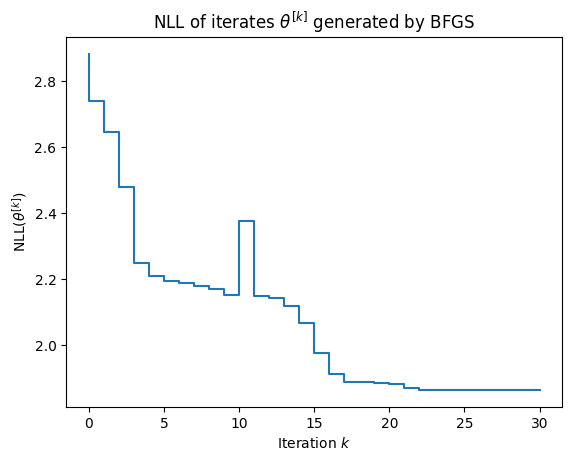

In [20]:
# This is a hacky way to get the valuations of NLL without having to rewrite BFGS

nll_bfgs = []

def nll_(θ):
    value = nll(θ)
    h = 1e-6
    jac = np.empty(θ.size)
    for i in range(θ.size):
        θ_ = θ.copy()
        θ_[i] += h
        jac[i] = (nll(θ_) - nll(θ)) / h
    nll_bfgs.append(value)
    return value, jac

θ_0 = unconstrain(0.5, Y.min(), Y.std(), Y.max(), Y.std())
result = optimize.minimize(nll_, θ_0, jac=True, method="BFGS")
plt.step(np.arange(len(nll_bfgs)), nll_bfgs)
plt.xlabel(r"Iteration $k$")
plt.ylabel(r"$\operatorname{NLL}(\theta^{[k]})$")
plt.title(r"NLL of iterates $\theta^{[k]}$ generated by BFGS");

## Expectation maximization (EM)

For brevity, let $Z$ denote the latent variables.
As usual, we use boldface notation to refer to multiple realizations (e.g., $\boldsymbol{y}$).

EM is a [fixed point iteration](https://en.wikipedia.org/wiki/Fixed-point_iteration) on the map

$$
T\theta \equiv \operatorname{argsup}_{\theta^\prime} \mathbb{E}_\theta \left[
    \log f_{\theta^\prime}(\boldsymbol{Y}, \boldsymbol{Z}) \mid \boldsymbol{Y} = \boldsymbol{y}
\right].
$$

**Proposition.** The iterates produced by EM have nondecreasing likelihood.

*Proof*.
First, note that, by the properties of the logarithm,

$$
T\theta=\operatorname{argsup}_{\theta^{\prime}}\mathbb{E}_{\theta}\left[\log\frac{f_{\theta^{\prime}}(\boldsymbol{Y},\boldsymbol{Z})}{f_{\theta}(\boldsymbol{Y},\boldsymbol{Z})}\middle|\boldsymbol{Y}=\boldsymbol{y}\right].
$$

Let $\theta$ be arbitrary parameter. Since $T\theta$ is a maximizer, it follows that

$$
\begin{align*}
0 & =\mathbb{E}_{\theta}\left[\log\frac{f_{\theta}(\boldsymbol{Y},\boldsymbol{Z})}{f_{\theta}(\boldsymbol{Y},\boldsymbol{Z})}\middle|\boldsymbol{Y}=\boldsymbol{y}\right]\\
 & \leq\mathbb{E}_{\theta}\left[\log\frac{f_{T\theta}(\boldsymbol{Y},\boldsymbol{Z})}{f_{\theta}(\boldsymbol{Y},\boldsymbol{Z})}\middle|\boldsymbol{Y}=\boldsymbol{y}\right]\\
 & =\log\frac{f_{T\theta}(\boldsymbol{y})}{f_{\theta}(\boldsymbol{y})}+\underbrace{\mathbb{E}_{\theta}\left[\log\frac{f_{T\theta}(\boldsymbol{Z}\mid\boldsymbol{Y})}{f_{\theta}(\boldsymbol{Z}\mid\boldsymbol{Y})}\middle|\boldsymbol{Y}=\boldsymbol{y}\right]}_{-D_{\mathrm{KL}}}\\
 & \leq\log\frac{f_{T\theta}(\boldsymbol{y})}{f_{\theta}(\boldsymbol{y})}
\end{align*}
$$

where the last inequality is a consequence of the nonnegativity of the [Kullback-Leibler](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) divergence.
Since $L(\theta) \equiv f_\theta(\boldsymbol{y})$ by definition, the desired result follows. $\blacksquare$

Returning to the mixture model, in order to set up the EM iteration, we first have to obtain an expression for $T\theta$.
For the mixture model, it will be helpful to consider only the coin flip as latent, and hence we set $Z \equiv \Delta$.
We denote realizations of $\Delta$ by the lower case letter $\delta$.
The joint density for a single sample $(y,\delta)$ is

$$
f_{\theta}(y,\delta)=f_{\theta}(y\mid\delta)f_{\theta}(\delta)=\left[\phi_{0}(y)\left(1-\pi\right)\right]^{1-\delta}\left[\phi_{1}(y)\pi\right]^{\delta}.
$$

Therefore,

$$
\log f_{\theta}(y,\delta)=\left(1-\delta\right)\left(\log\phi_{0}(y)+\log(1-\pi)\right)+\delta\left(\log\phi_{1}(y)+\log\pi\right).
$$

Moreover, since

$$
f_{\theta}(\delta\mid y)=\frac{f_{\theta}(y\mid\delta)f_{\theta}(\delta)}{f_{\theta}(y)}=\frac{\left[\phi_{0}(y)\left(1-\pi\right)\right]^{1-\delta}\left[\phi_{1}(y)\pi\right]^{\delta}}{\phi_{0}(y)\left(1-\pi\right)+\phi_{1}(y)\pi},
$$

it follows that

$$
\mathbb{E}_{\theta}\left[\Delta\mid Y=y\right]=\frac{\phi_{1}(y)\pi}{\phi_{0}(y)\left(1-\pi\right)+\phi_{1}(y)\pi}.
$$

Putting this all together,

$$
T\theta
\equiv \operatorname{argsup}_{\theta} T(\theta, \theta^\prime)
=\operatorname{argsup}_{\theta^\prime}\sum_{n}\log\phi(y_{n};\mu_{0}^{\prime},\sigma_{0}^{\prime})+\log(1-\pi^{\prime})+\mathbb{E}_{\theta}\left[\Delta\mid Y=y_{n}\right]\left(\log\frac{\phi(y_{n};\mu_{1}^{\prime},\sigma_{1}^{\prime})}{\phi(y_{n};\mu_{0}^{\prime},\sigma_{0}^{\prime})}+\log\frac{\pi^{\prime}}{1-\pi^{\prime}}\right).
$$

Next, let 

$$
\xi_{n}(\theta)\equiv\mathbb{E}_{\theta}\left[\Delta\mid Y=y_{n}\right].
$$

Note that

$$
\begin{align*}
\frac{\partial\log\phi(y;\mu,\sigma)}{\partial\mu} & =\frac{y-\mu}{\sigma^{2}}\\
\frac{\partial\log\phi(y;\mu,\sigma)}{\partial\sigma} & =\frac{1}{\sigma}\left(\frac{\left(y-\mu\right)^{2}}{\sigma^{2}}-1\right).
\end{align*}
$$

Therefore, differentiating $T(\theta,\theta^{\prime})$ yields

$$
\begin{align*}
\frac{\partial T(\theta,\theta^{\prime})}{\partial\pi^{\prime}} & =\frac{1}{\pi^{\prime}\left(1-\pi^{\prime}\right)}\left[-N\pi^{\prime}+\sum_{n}\xi_{n}(\theta)\right]\\
\frac{\partial T(\theta,\theta^{\prime})}{\partial\mu_{0}^{\prime}} & =\frac{1}{\left(\sigma_{0}^{\prime}\right)^{2}}\left[-\mu_{0}^{\prime}\sum_{n}\left(1-\xi_{n}(\theta)\right)+\sum_{n}\left(1-\xi_{n}(\theta)\right)y_{n}\right]\\
\frac{\partial T(\theta,\theta^{\prime})}{\partial\sigma_{0}^{\prime}} & =\frac{1}{\left(\sigma_{0}^{\prime}\right)^{3}}\left[-\left(\sigma_{0}^{\prime}\right)^{2}\sum_{n}\left(1-\xi_{n}(\theta)\right)+\sum_{n}\left(1-\xi_{n}(\theta)\right)\left(y_{n}-\mu_{0}^{\prime}\right)^{2}\right]\\
\frac{\partial T(\theta,\theta^{\prime})}{\partial\mu_{1}^{\prime}} & =\frac{1}{\left(\sigma_{1}^{\prime}\right)^{2}}\left[-\mu_{1}^{\prime}\sum_{n}\xi_{n}(\theta)+\sum_{n}\xi_{n}(\theta)y\right].\\
\frac{\partial T(\theta,\theta^{\prime})}{\partial\sigma_{0}^{\prime}} & =\frac{1}{\left(\sigma_{1}^{\prime}\right)^{3}}\left[-\left(\sigma_{1}^{\prime}\right)^{2}\sum_{n}\xi_{n}(\theta)+\sum_{n}\xi_{n}(\theta)\left(y_{n}-\mu_{1}^{\prime}\right)^{2}\right]
\end{align*}
$$

Letting $\theta^{[k]}$ denote the $k$-th iterate of EM and $\boldsymbol{\xi}^{[k]}\equiv(\xi_{1}(\theta^{[k]}),\ldots,\xi_{N}(\theta^{[k]}))^{\intercal}$, it follows that the equations for the $(k+1)$-th iterate are

$$
\begin{align*}
\pi^{[k+1]} & =\frac{1}{N}\boldsymbol{1}^{\intercal}\boldsymbol{\xi}^{[k]}\\
\mu_{0}^{[k+1]} & =\frac{\boldsymbol{y}^{\intercal}\left(\boldsymbol{1}-\boldsymbol{\xi}^{[k]}\right)}{\boldsymbol{1}^{\intercal}\left(\boldsymbol{1}-\boldsymbol{\xi}^{[k]}\right)}\\
\sigma_{0}^{[k+1]} & =\sqrt{\frac{\operatorname{tr}\Bigl(\left(\boldsymbol{y}-\mu_{0}^{[k+1]}\right)\operatorname{diag}(1-\boldsymbol{\xi})\left(\boldsymbol{y}-\mu_{0}^{[k+1]}\right)^{\intercal}\Bigr)}{\boldsymbol{1}^{\intercal}\left(\boldsymbol{1}-\boldsymbol{\xi}\right)}}\\
\mu_{1}^{[k+1]} & =\frac{\boldsymbol{y}^{\intercal}\boldsymbol{\xi}^{[k]}}{\boldsymbol{1}^{\intercal}\boldsymbol{\xi}^{[k]}}\\
\sigma_{1}^{[k+1]} & =\sqrt{\frac{\operatorname{tr}\Bigl(\left(\boldsymbol{y}-\mu_{1}^{[k+1]}\right)\operatorname{diag}(\boldsymbol{\xi})\left(\boldsymbol{y}-\mu_{1}^{[k+1]}\right)^{\intercal}\Bigr)}{\boldsymbol{1}^{\intercal}\boldsymbol{\xi}}}.
\end{align*}
$$

In [12]:
def em_update(π, μ_0, σ_0, μ_1, σ_1):
    φ_0 = stats.norm.pdf(Y, loc=μ_0, scale=σ_0)
    φ_1 = stats.norm.pdf(Y, loc=μ_1, scale=σ_1)
    # The code below is optimized for readability, not speed
    ξ = φ_1 * π / (φ_0 * (1. - π) + φ_1 * π)
    π = ξ.mean()
    μ_0 = Y @ (1. - ξ) / (1. - ξ).sum()
    σ_0 = np.sqrt((1. - ξ) @ (Y - μ_0)**2 / (1. - ξ).sum())
    μ_1 = Y @ ξ / ξ.sum()
    σ_1 = np.sqrt(ξ @ (Y - μ_1)**2 / ξ.sum())
    return π, μ_0, σ_0, μ_1, σ_1

In [13]:
# Use the same initial guess as in Newton's method
π_k, μ_0_k, σ_0_k, μ_1_k, σ_1_k = constrain(θ_0)
for _ in range(10):
    π_k, μ_0_k, σ_0_k, μ_1_k, σ_1_k = em_update(π_k, μ_0_k, σ_0_k, μ_1_k, σ_1_k)

As shown below, EM converges in just a few iterations.
Near convergence, the NLL can be non-monotone up to noise due purely to floating point error.

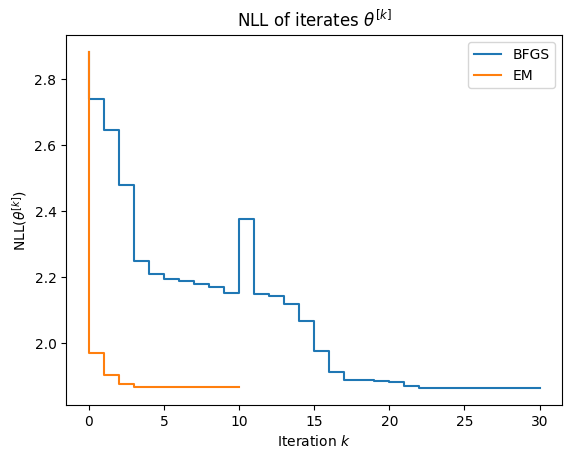

In [14]:
π_k, μ_0_k, σ_0_k, μ_1_k, σ_1_k = constrain(θ_0)
value = nll(unconstrain(π_k, μ_0_k, σ_0_k, μ_1_k, σ_1_k))
nll_em = [value]
for _ in range(10):
    π_k, μ_0_k, σ_0_k, μ_1_k, σ_1_k = em_update(π_k, μ_0_k, σ_0_k, μ_1_k, σ_1_k)
    value = nll(unconstrain(π_k, μ_0_k, σ_0_k, μ_1_k, σ_1_k))
    nll_em.append(value)

plt.step(np.arange(len(nll_bfgs)), nll_bfgs, label="BFGS")
plt.step(np.arange(len(nll_em)), nll_em, label="EM")
plt.xlabel(r"Iteration $k$")
plt.ylabel(r"$\operatorname{NLL}(\theta^{[k]})$")
plt.legend()
plt.title(r"NLL of iterates $\theta^{[k]}$");

In [15]:
tabulate(
    [
        ("Exact", π, μ_0, σ_0, μ_1, σ_1),
        ("BFGS", ) + constrain(result.x),
        ("EM", π_k, μ_0_k, σ_0_k, μ_1_k, σ_1_k)
    ],
    headers=("", "π", "μ_0", "σ_0", "μ_1", "σ_1"),
    tablefmt="html",
)

'<table>\n<thead>\n<tr><th>     </th><th style="text-align: right;">       π</th><th style="text-align: right;">     μ_0</th><th style="text-align: right;">     σ_0</th><th style="text-align: right;">    μ_1</th><th style="text-align: right;">     σ_1</th></tr>\n</thead>\n<tbody>\n<tr><td>Exact</td><td style="text-align: right;">0.5     </td><td style="text-align: right;">1       </td><td style="text-align: right;">0.7     </td><td style="text-align: right;">5      </td><td style="text-align: right;">1       </td></tr>\n<tr><td>BFGS </td><td style="text-align: right;">0.523454</td><td style="text-align: right;">0.963808</td><td style="text-align: right;">0.628632</td><td style="text-align: right;">4.90962</td><td style="text-align: right;">0.995069</td></tr>\n<tr><td>EM   </td><td style="text-align: right;">0.523328</td><td style="text-align: right;">0.964187</td><td style="text-align: right;">0.629008</td><td style="text-align: right;">4.91024</td><td style="text-align: right;">0.994388</td></tr>\n</tbody>\n</table>'

## Markov Chain Monte Carlo (MCMC)

So far we have treated true parameter $\theta$ as a constant.
Bayesian methods treat it as a random variable with [prior density](https://en.wikipedia.org/wiki/Prior_probability) $f(\theta)$.
Priors express our beliefs about the parameter before seeing (i.e., unconditional on) data.
After data is observed, we obtain the posterior, reflecting our updated beliefs:

$$
f(\theta \mid \boldsymbol{y})
= \frac{f(\boldsymbol{y} \mid \theta) f(\theta)}{f(\boldsymbol{y})}
= \frac{f(\boldsymbol{y} \mid \theta) f(\theta)}{\int f(\boldsymbol{y},\theta) f(\theta) d\theta}
\propto f(\boldsymbol{y} \mid \theta) f(\theta).
$$

That is, *the posterior is proportional to the likelihood times the prior*:

$$
f(\theta \mid \boldsymbol{y}) \propto L(\theta) f(\theta).
$$

One can imagine any number of Bayesian estimators constructed from the posterior.
Any one of the mean, median, or mode of the posterior produce reasonable estimators.

Below is an example using [PyMC](https://www.pymc.io) to compute a highest density interval (HDI), a form of credible interval, for the parameter dimensions.
Reasonable priors for each dimension are chosen (e.g., $\pi \sim \operatorname{Uniform}(0, 1)$).

In [16]:
with pymc.Model() as model:
    π_rv = pymc.Uniform("π", lower=0., upper=1.)
    μ_0_rv = pymc.Normal("μ_0", mu=np.quantile(Y, 0.25), sigma=1.)
    σ_0_rv = pymc.HalfNormal("σ_0", sigma=1.)
    μ_1_rv = pymc.Normal("μ_1", mu=np.quantile(Y, 0.75), sigma=1.)
    σ_1_rv = pymc.HalfNormal("σ_1", sigma=1.)
    Y_0_dist = pymc.Normal.dist(mu=μ_0_rv, sigma=σ_0_rv)
    Y_1_dist = pymc.Normal.dist(mu=μ_1_rv, sigma=σ_1_rv)
    likelihood = pymc.Mixture("Y", w=[π_rv, 1. - π_rv], comp_dists=[Y_0_dist, Y_1_dist], observed=Y)
    trace = pymc.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [π, μ_0, σ_0, μ_1, σ_1]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


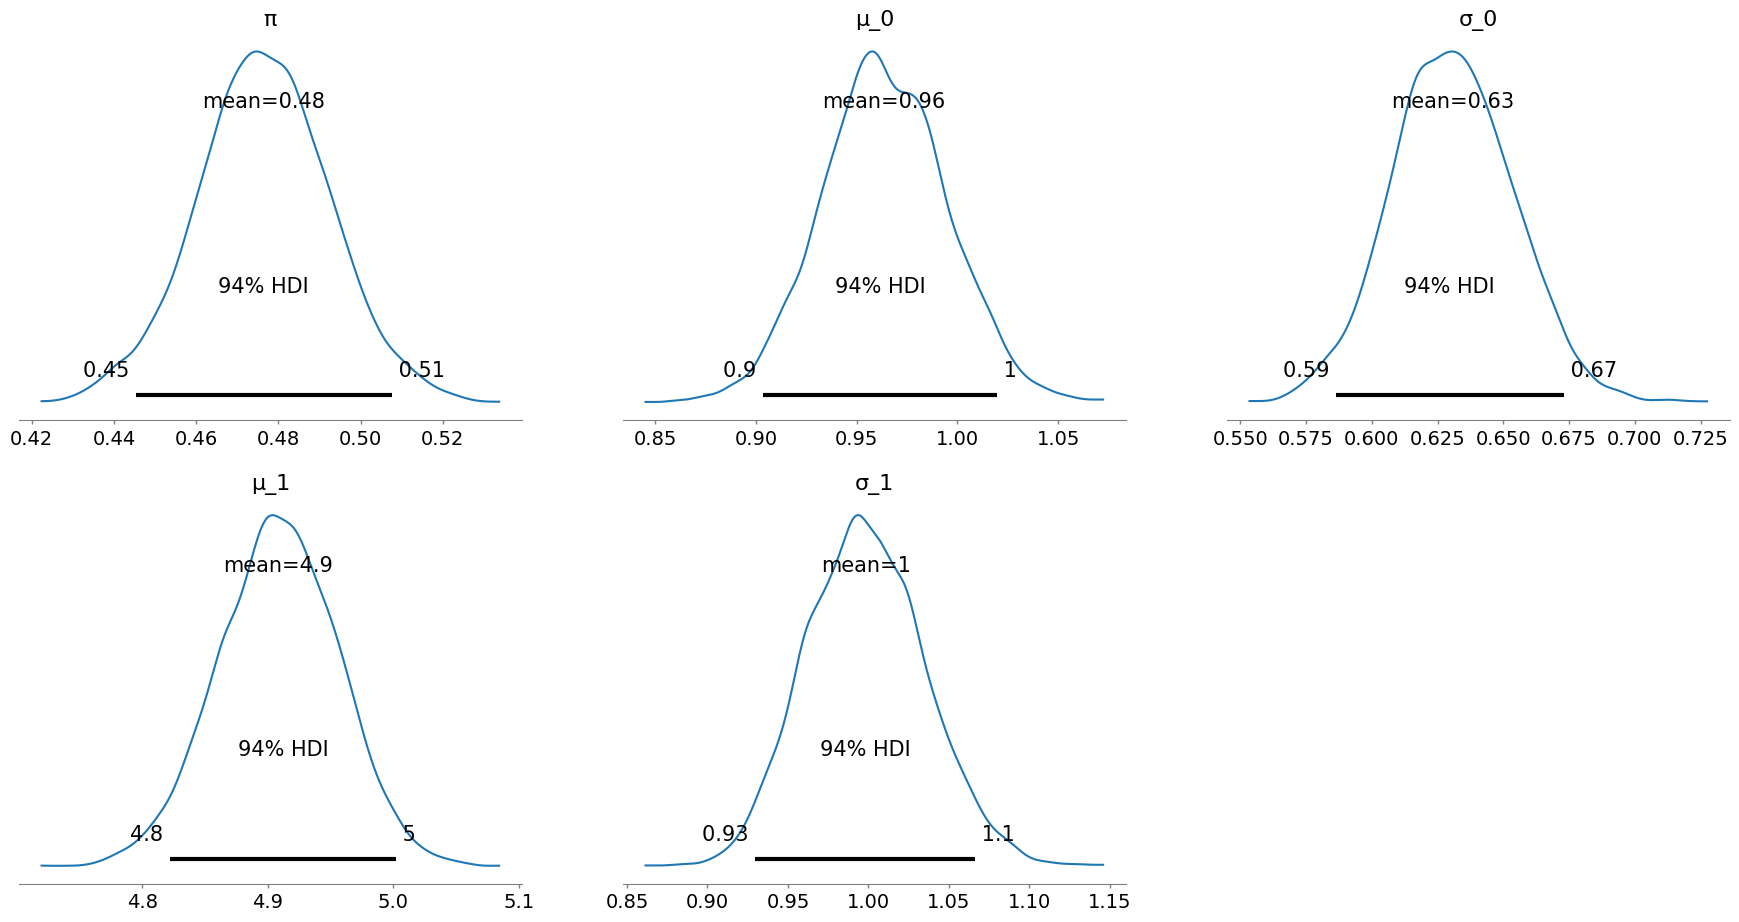

In [17]:
pymc.plot_posterior(trace, var_names=["π", "μ_0", "σ_0", "μ_1", "σ_1"]);